In [1]:
from src.data_loader import load_train, load_holdout
from src.preprocess import preprocess_data
from src.model_io import load_best_model
from src.plot import plot_gain_importance, get_xgb_gain_importance, get_permutation_importance, plot_shap_summary
from sklearn.model_selection import train_test_split
import shap
from ydata_profiling import ProfileReport
from src.train import train_xgboost
from src.evaluate import find_best_threshold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

🧹 Removed users with missing rate ≥ 10%: 156 rows dropped (51047 → 50891)
Best best_t: 0.38, Best F1-score: 0.5043655743281551


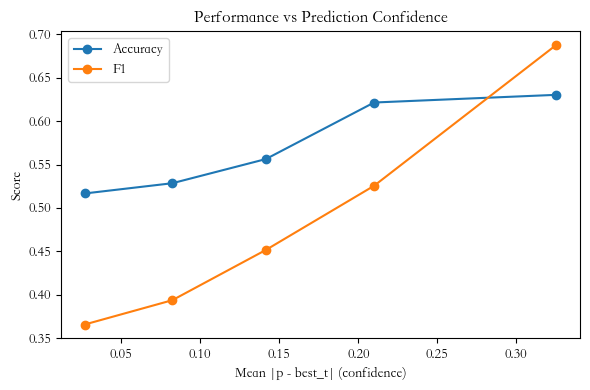

In [2]:
df = preprocess_data(load_train())

target = "Churn"
id_col = "CustomerID"

X = df.drop(columns=[target, id_col])
y = df[target]


X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


model = train_xgboost(X_train, y_train)

best_t, best_f1 = find_best_threshold(model, X_valid, y_valid)
print(f"Best best_t: {best_t}, Best F1-score: {best_f1}")

y_proba = model.predict_proba(X_valid)[:, 1]
confidence = np.abs(y_proba - best_t)

df_eval = pd.DataFrame({
    "y_true": y_valid,
    "y_proba": y_proba,
    "confidence": confidence
})

df_eval["conf_bin"] = pd.qcut(
    df_eval["confidence"],
    q=5,              # 分 5 桶（你也可以 10）
    labels=False
)

from sklearn.metrics import accuracy_score, f1_score

results = []

for b in sorted(df_eval["conf_bin"].unique()):
    sub = df_eval[df_eval["conf_bin"] == b]
    
    y_pred = (sub["y_proba"] >= best_t).astype(int)
    
    results.append({
        "bin": b,
        "n_samples": len(sub),
        "mean_confidence": sub["confidence"].mean(),
        "accuracy": accuracy_score(sub["y_true"], y_pred),
        "f1": f1_score(sub["y_true"], y_pred)
    })

result_df = pd.DataFrame(results)
result_df

plt.figure(figsize=(6,4))
plt.plot(result_df["mean_confidence"], result_df["accuracy"], marker="o", label="Accuracy")
plt.plot(result_df["mean_confidence"], result_df["f1"], marker="o", label="F1")
plt.xlabel("Mean |p - best_t| (confidence)")
plt.ylabel("Score")
plt.title("Performance vs Prediction Confidence")
plt.legend()
plt.tight_layout()
plt.show()